### Res-net blocks + LSTM, with helpers

In [ ]:
# The combination of LSTM and Res-net blocks, pretrained torques with helpers.

In [1]:
import sys
import torch

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io as sio

from utils import *
from torchsummary import summary
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)
import os      
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"   

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
I_train, I_test, _, _, Tep_train, Tep_test, q_us_train, q_us_test, dqdt_us_train, dqdt_us_test = load_data()


I_mu = I_train.mean(axis=0)
I_sigma = I_train.std(axis=0)
I_sc_train = (I_train - I_mu)/I_sigma

I_sc_test = (I_test - I_mu)/I_sigma

torques_sc_train = sio.loadmat('../data/mat/scaled_data/outandpred_torque0_train.mat')['trainingDataOutput']
torques_sc_test = sio.loadmat('../data/mat/scaled_data/outandpred_torque0_test.mat')['testDataOutput']
torques_sc_train = torch.from_numpy(torques_sc_train).to(device).float()
torques_sc_test = torch.from_numpy(torques_sc_test).to(device).float()

torques_sc_train = torques_sc_train
torques_sc_test = torques_sc_test

helpers_train = torques_sc_train[...,50:]
helpers_test = torques_sc_test[...,50:]


In [3]:
# For the computing loss function. From best_LSTM net loss function

def diff_torch_conv_1d(inputs, method='2erStencil'):
    if  method=='3erStencil':
        filters = 0.5*torch.tensor([[[1.,  -2., 1.]]], requires_grad=False).to(device)
    elif  method=='2erStencil':
        filters = torch.tensor([[[1.,  -1.]]], requires_grad=False).to(device)
    return F.conv1d(inputs[:,None], filters, bias=None, padding=0)[:,0]



In [4]:
class Big_Sep_Net(nn.Module):

    def __init__(self):
        super(Big_Sep_Net, self).__init__()
        
        self.which_net = 0
        
        self.w1 = torch.nn.Parameter(data=torch.Tensor(50, 30, 11), requires_grad=True)
        self.w1.data.uniform_(-1, 1)
        
        self.b1 = torch.nn.Parameter(data=torch.Tensor(50, 11), requires_grad=True)
        self.b1.data.uniform_(-1, 1)      
        
        self.w2 = torch.nn.Parameter(data=torch.Tensor(50, 11, 11), requires_grad=True)
        self.w2.data.uniform_(-1, 1)
        
        self.b2 = torch.nn.Parameter(data=torch.Tensor(50, 11), requires_grad=True)
        self.b2.data.uniform_(-1, 1)
        
        self.w3 = torch.nn.Parameter(data=torch.Tensor(50, 11, 11), requires_grad=True)
        self.w3.data.uniform_(-1, 1)
        
        self.b3 = torch.nn.Parameter(data=torch.Tensor(50, 11), requires_grad=True)
        self.b3.data.uniform_(-1, 1)
        
        self.w4 = torch.nn.Parameter(data=torch.Tensor(50, 11, 10), requires_grad=True)
        self.w4.data.uniform_(-1, 1)
        
        self.b4 = torch.nn.Parameter(data=torch.Tensor(50, 10), requires_grad=True)
        self.b4.data.uniform_(-1, 1)

        self.w5 = torch.nn.Parameter(data=torch.Tensor(50, 10, 1), requires_grad=True)
        self.w5.data.uniform_(-1, 1)
        
        self.b5 = torch.nn.Parameter(data=torch.Tensor(50, 1), requires_grad=True)
        self.b5.data.uniform_(-1, 1)
        
    def forward(self, Is):
        
        x = Is[:,None]
        
        
        x = torch.einsum('ijk,jkl->ijl', x, self.w1) + self.b1
        x = nn.ReLU()(x)

        
        x = x + nn.ReLU()( torch.einsum('ijk,jkl->ijl', x, self.w2) + self.b2 )
        
        x = x + nn.ReLU()( torch.einsum('ijk,jkl->ijl', x, self.w3) + self.b3 )
        
        x = nn.ReLU()( torch.einsum('ijk,jkl->ijl', x, self.w4) + self.b4 )
        
        dqdts = torch.einsum('ijk,jkl->ijl', x, self.w5) + self.b5

        return dqdts.squeeze()

In [5]:
class LSTM_HelpTorq(torch.nn.Module):
    def __init__(self):
        
        super(LSTM_HelpTorq, self).__init__()
        
        self.lstm1 = torch.nn.LSTM(31, 1, num_layers=1, batch_first=True)
        self.lstm2 = torch.nn.LSTM(31, 1, num_layers=1, batch_first=True)
        
        
        self.d1 = torch.nn.Linear(50,50)
        self.d2 = torch.nn.Linear(30, 60)
        self.d3 = torch.nn.Linear(60, 90)
        self.d4 = torch.nn.Linear(90, 110)
    
        self.d5 = torch.nn.Linear(160, 160)     
        self.d6 = torch.nn.Linear(160, 160)      
        self.d7 = torch.nn.Linear(160, 160)      
        self.d8 = torch.nn.Linear(160, 160)    
        
        
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        
        self.torque_net = torch.load('models/big_sep_net_only_torques.pt') #  models/sep_torque_net_without_helpers_1.pt
        
    def forward(self, Is):
        
        with torch.no_grad():    # keep the torque_net, i.e. the Separate-Net

            torques = self.torque_net(Is)
        
        torques = torques + self.tanh( self.d1(torques) )
        
        x = torch.cat((torques[..., None],
                       Is[:, None].repeat(1, 50, 1),), axis=-1)
        
        torques, _ = self.lstm1(x)
        torques = torques.squeeze()
        
        
        ### Getting helpers from the initial conditions
        
        helpers = self.tanh( self.d2(Is) )
        helpers = self.tanh( self.d3(helpers) )
        helpers = self.d4(helpers)
        
        
        ### Torques and concatinated helpers and initial conditions to the LSTM layer 
        
        x = torch.cat((torques,helpers), axis=1)
        
        x = torch.cat(( x[..., None],
                       Is[:, None].repeat(1, 160, 1),), axis=-1)
        
        x, _ = self.lstm2(x)
        
        x = x.squeeze()
        
        x = x + self.tanh(x)
        
        
        ### Res-net part
        
        x = x + self.tanh( self.d5(x) )
        x = x + self.tanh( self.d6(x) )
        x = x + self.tanh( self.d7(x) )
        x = x + self.tanh( self.d8(x) )
        
        return x

In [6]:
net = torch.load('models/LSTM_HelpTorq_LossDiff.pt')
summary(net);

In [8]:
def trainer(batch_size = 3200, epochs = 50, lr = 0.001):
    net.train()
    
    for epoch in range(1, epochs + 1):
        trainloader = torch.utils.data.DataLoader(
                                            torch.arange(len(I_train_sc)), 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            drop_last=False)

        running_loss = 0
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)

        for i, batch_indxs in enumerate(trainloader, 0):

            torques_sc_target_batch = torques_sc_train[batch_indxs]
            
                
            Is = I_train_sc[batch_indxs]
               
            torques_sc_pred = net(Is)
            
            
            
            LossDiff = nn.SmoothL1Loss()( diff_torch_conv_1d(torques_sc_pred[...,:50]), diff_torch_conv_1d(torques_sc_target_batch[...,:50]) )
                
            loss_1 = nn.SmoothL1Loss()(torch.abs(torques_sc_pred)**1*( (torques_sc_pred>0)*1.-(torques_sc_pred<0)*1.), \
                                     
                                    torch.abs(torques_sc_target_batch)**1*( (torques_sc_target_batch>0)*1.-(torques_sc_target_batch<0)*1.) )
                
                
            loss = loss_1 + LossDiff
            
            
            
            
            loss_torques = torch.nn.MSELoss()(torques_sc_pred[...,:50], torques_sc_target_batch[...,:50])         
            
            running_loss += loss_torques.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            percent = (i + 1) / len(trainloader) * 100
            print(f'Epoch {epoch} \t{loss.item():.8f}\t{loss_1.item():.8f}\t{loss_torques.item():.8f}\t{percent:.0f}%', end='\r')

        print('\nAverage loss =', running_loss / len(trainloader))
    

In [ ]:
batch_size = 320
epochs = 100
lr = 0.0001

trainer(batch_size=batch_size, epochs=epochs, lr=lr)

In [9]:
print('Accuracy (only torques) --->', torch.nn.MSELoss()(torques_sc_test[...,:50],net(I_sc_test)[...,:50]).item())


Accuracy (only torques) ---> 0.0030575443524867296


In [10]:
# torch.save(net, 'models/LSTM_HelpTorq.pt')

In [11]:
net.eval();

I_all = torch.cat((I_sc_train, I_sc_test))
torques_all = torch.cat((torques_sc_train, torques_sc_test))[..., :50]

loss = 0

f = torch.nn.MSELoss()

c = 0
for i in range(0, I_all.size(0), 10000):
    out = net(I_all[i:i+10000])[..., :50]
    loss += f(out, torques_all[i:i+10000]).item()
    c += 1

print('MSE Loss on (train + test) =', loss/c)


MSE Loss on (train + test) = 0.0018039338756352663


In [12]:
net.eval();

I_all = I_sc_train
torques_all = torques_sc_train

loss = 0

f = torch.nn.MSELoss()

c = 0
for i in range(0, I_all.size(0), 10000):
    out = net(I_all[i:i+10000])[..., :50]
    loss += f(out, torques_all[i:i+10000, ..., :50]).item()
    c += 1

print('MSE Loss on (train + test) =', loss/c)

MSE Loss on (train + test) = 0.001582873652556113


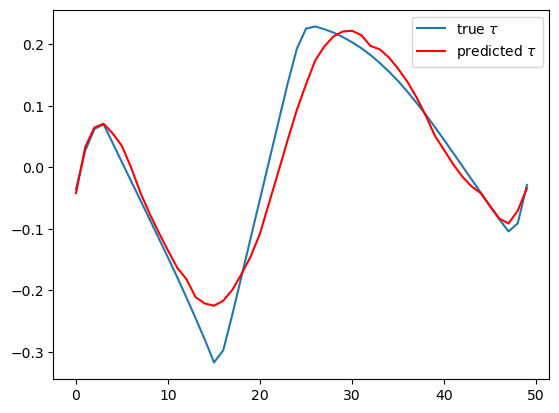

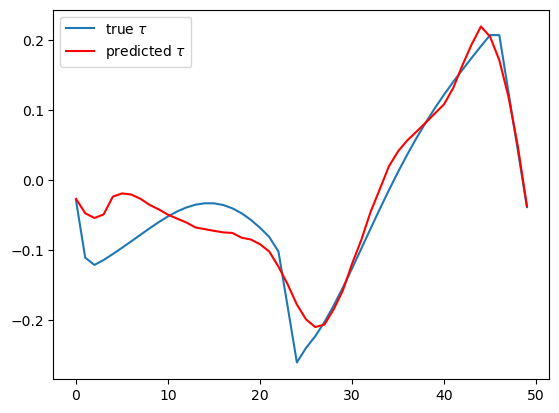

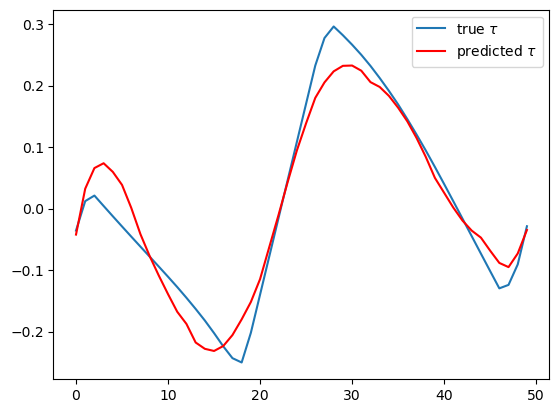

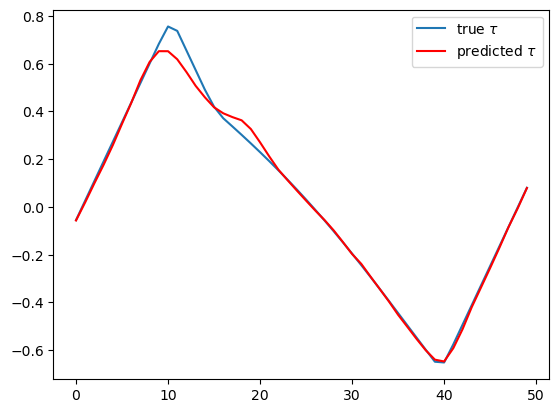

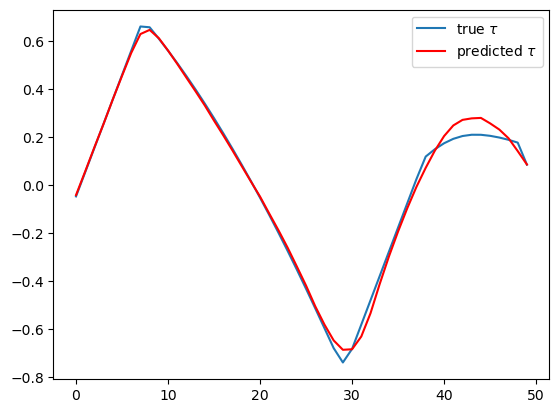

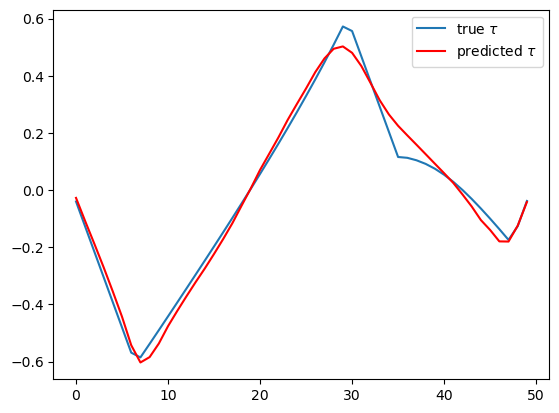

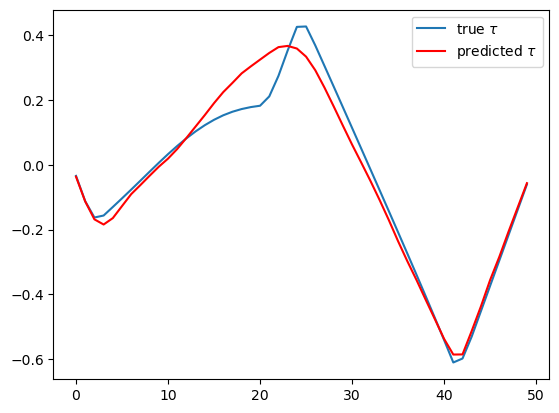

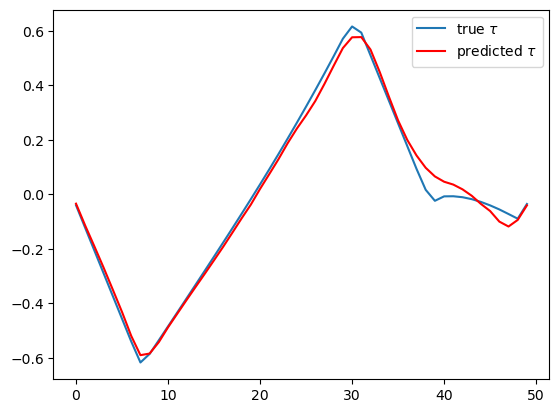

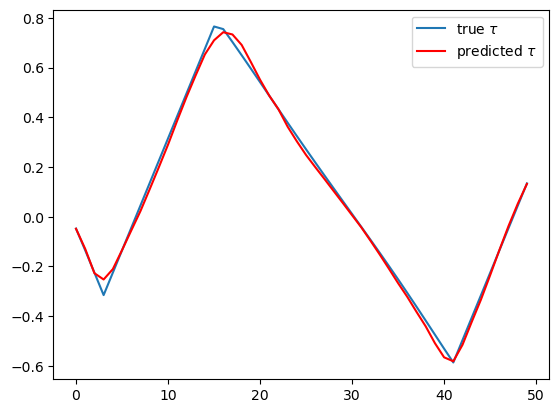

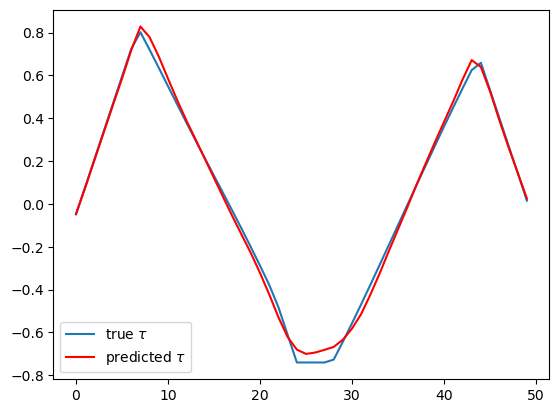

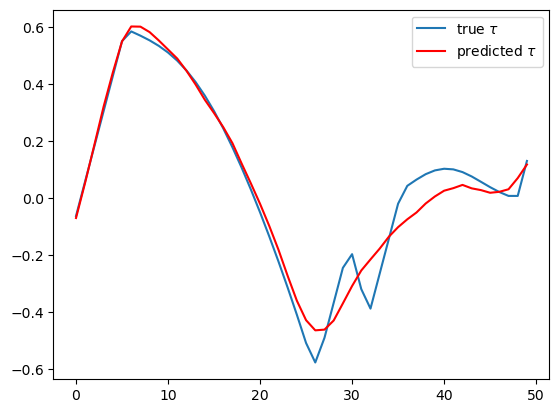

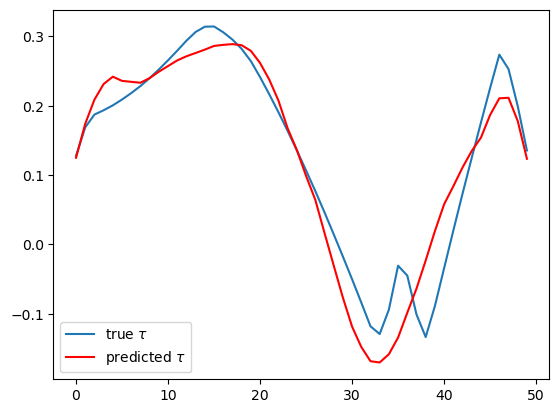

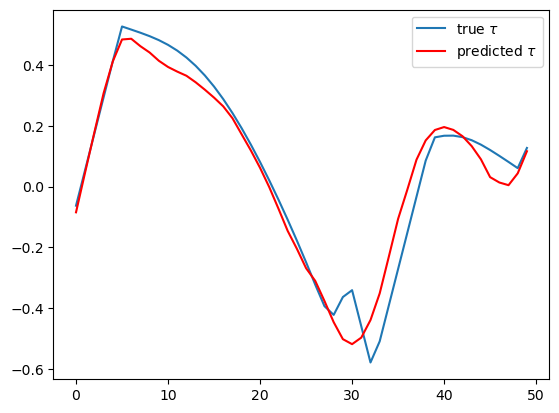

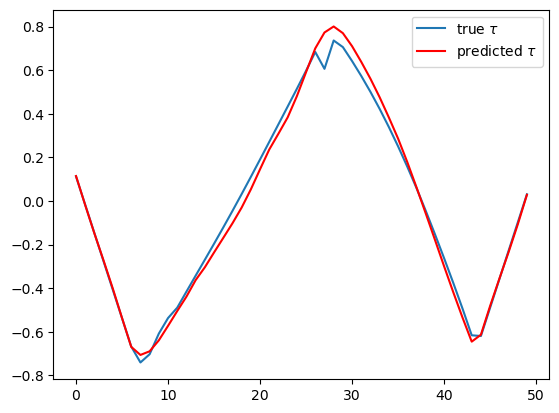

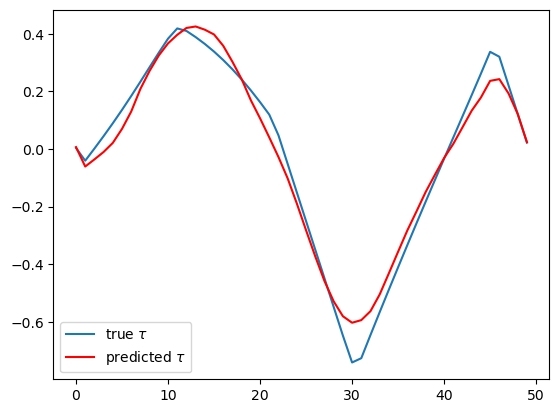

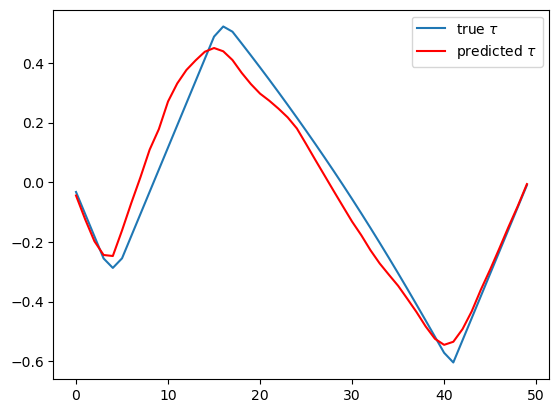

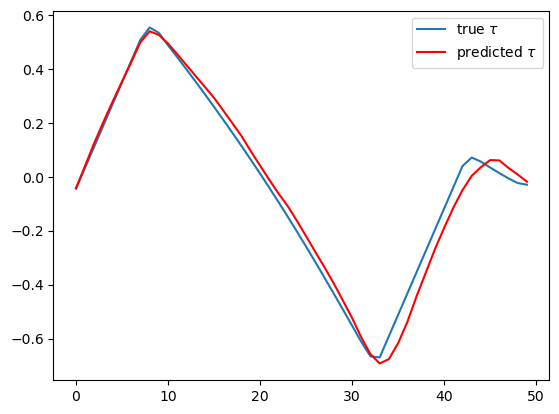

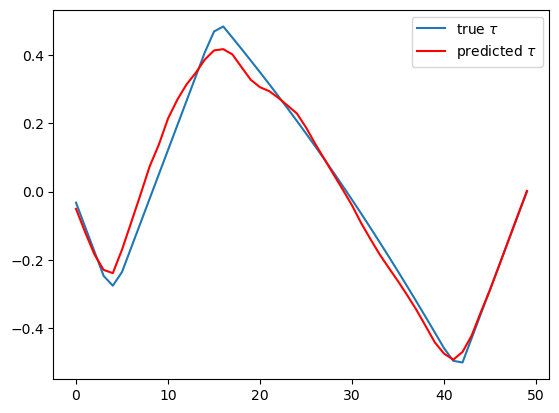

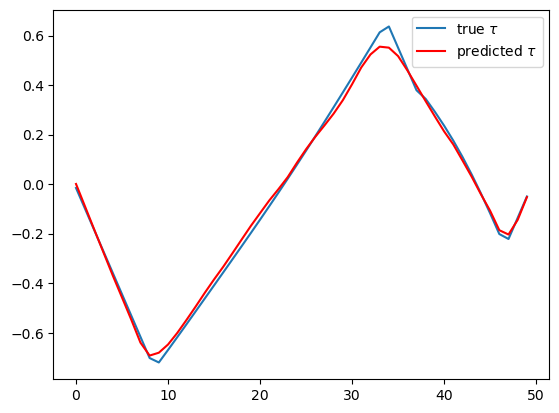

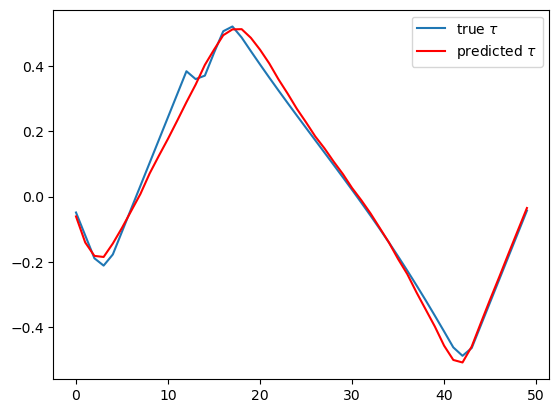

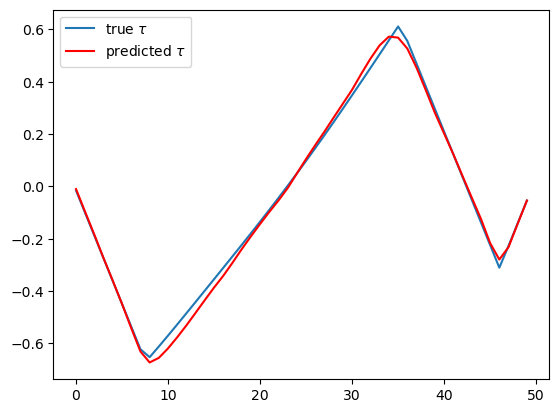

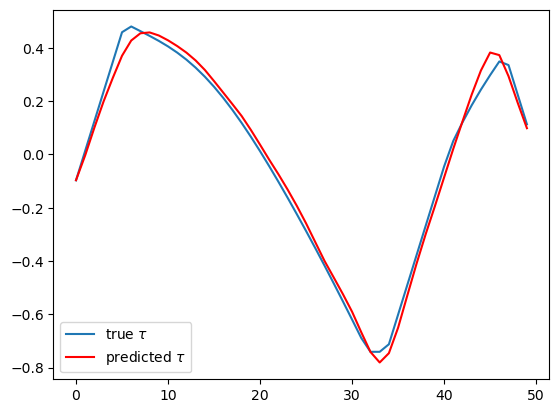

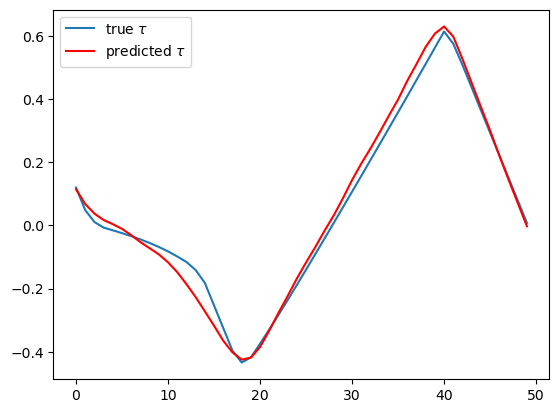

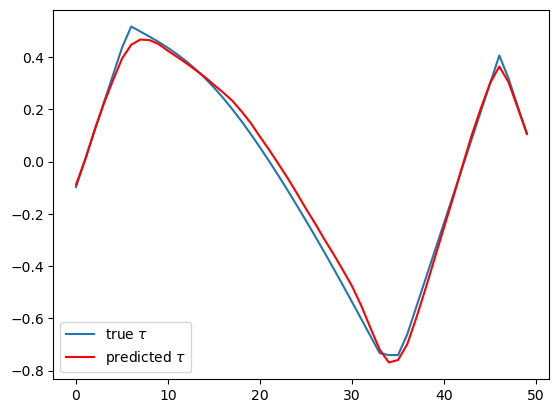

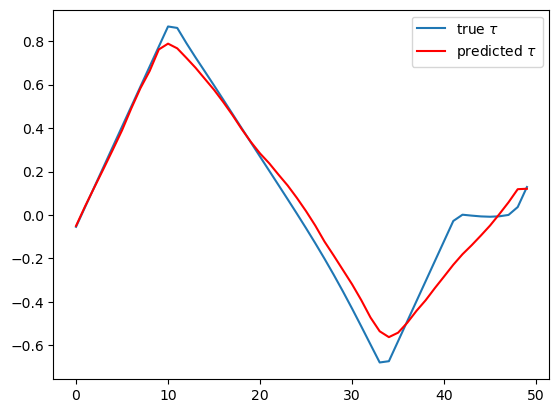

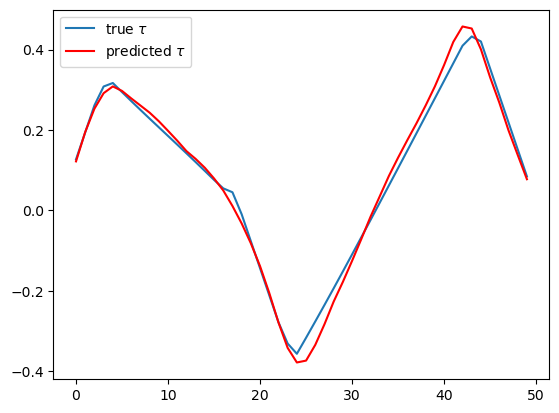

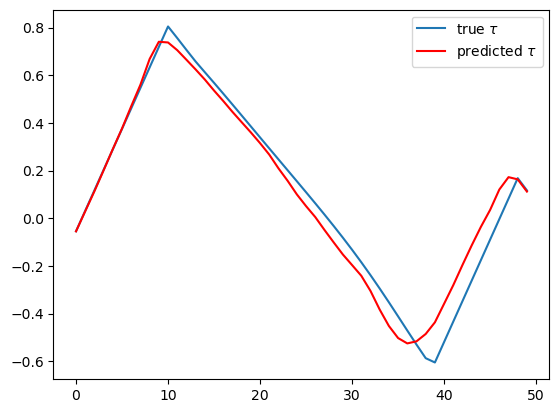

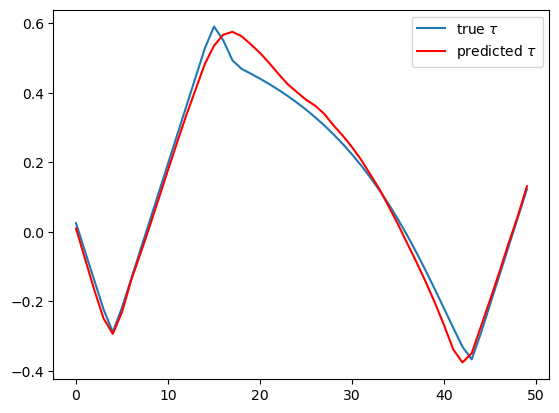

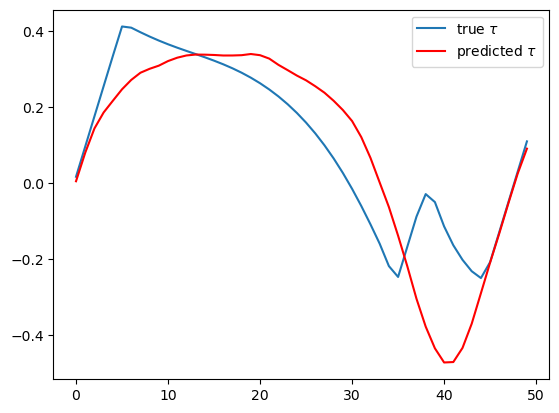

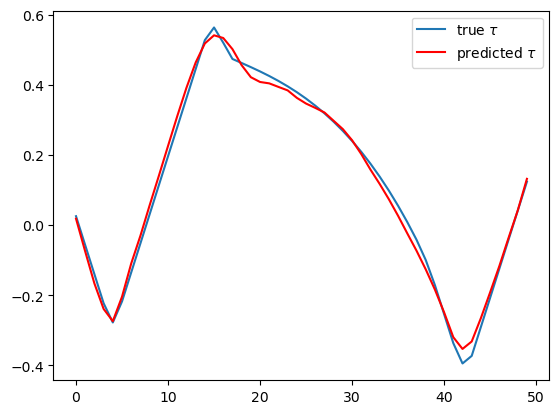

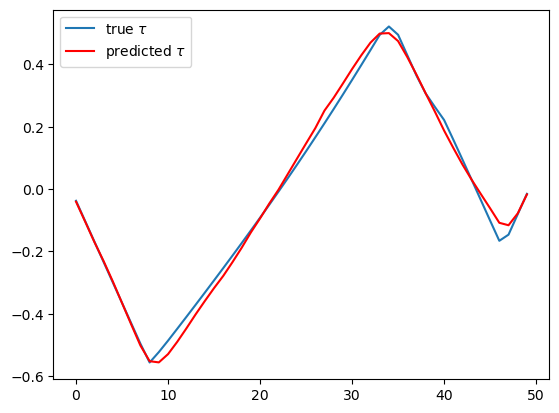

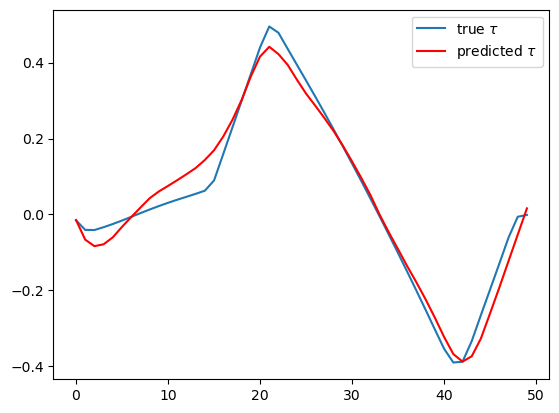

In [14]:
torque_out = net(I_sc_test[:32])


for i in range(32):
    
    plt.plot(torques_sc_test[i][:50].detach().cpu(), label = 'true $\\tau$')
    plt.plot(torque_out[i][:50].detach().cpu(), color = 'r', label = 'predicted $\\tau$')
    
#     plt.scatter(torch.arange(0,50)*50/150, torque_out[...,::3][i].detach().cpu(), color = 'blue', label = 'predicted $\\tau$')
#     plt.scatter(torch.arange(0,150)*50/150, torque_out[i].detach().cpu(), color = 'r', label = 'predicted $\\tau$')
#     plt.scatter(torch.arange(0,150)*50/150, spline_func(torques_sc_test[i,:50][None]).detach().cpu(), alpha = 0.4)
    plt.legend()
    
    plt.show()